# Analyze movement based on Accelerometer Data

In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from collections import namedtuple
from itertools import compress
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from  matplotlib import __version__ as plt_version
from scipy import signal, stats

# import datetime as dt
# #mne
# import mne_bids
# import mne


In [2]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [3]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')


In [4]:
os.chdir(codepath)

# own functions
import lfpecog_features.moveDetection_preprocess as movePrep
import lfpecog_features.moveDetection_run as run_tap_detect
import lfpecog_features.moveDetection_pausedTapFinder as findTap

import lfpecog_analysis.load_SSD_features as load_ssd_fts

import utils.utils_fileManagement as utilsFiles
from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)
import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_plotting.plotHelpers as plotHelp

In [5]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('matplotlib', plt_version)

Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
matplotlib 3.5.3


### 0. Define available Subjects


In [6]:
import lfpecog_analysis.movement_psd_analysis as movePSD
import lfpecog_features.feats_helper_funcs as ftHelpers
import lfpecog_analysis.prep_movement_psd_analysis as prepTapPSD

In [7]:
FT_VERSION='v7'
data_version = 'v4.2'
main_data_path = os.path.join(get_project_path('data'),
                              'merged_sub_data',
                              data_version)

SUBS = load_ssd_fts.get_avail_ssd_subs(DATA_VERSION=data_version,
                                       FT_VERSION=FT_VERSION)
print(len(SUBS))

new_subs = ['110',  '022',]


19


### 1a. Load pickled acc-data (and plot Taps)


In [101]:
importlib.reload(prepTapPSD)

starts, ends = prepTapPSD.get_tap_times(sub='017',
                                        DATA_VERSION='v4.0',
                                        return_in_secs=True)

win_times = np.linspace(45, 55, 4300)

win_bool = prepTapPSD.select_taps_out_window(win_times,
                                             starts,
                                             ends)

custom tap finding: 017, left
custom tap finding: 017, right


In [25]:
def plot_tap_interactive(
    sub, fsize=14, SAVE_FIG=False,
    custom_tappers=['105', '017', '010']
):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    sub_data_path = os.path.join(get_project_path('data'),
                              'merged_sub_data',
                              data_version,
                              f'sub-{sub}')


    # plot both tap data columns
    if sub not in custom_tappers:
        fname = (f'{sub}_mergedData_{data_version}'
            '_acc_left.P')
        # load Acc-detected movement labels
        acc = load_class_pickle(os.path.join(sub_data_path, fname))
        print(f'\t...sub-{sub}: loaded Acc-Pickle')
        acc = correct_acc_class(acc)
        for s in ['left', 'right']:
                i = np.where([c == f'{s}_tap' for c in acc.colnames])[0][0]
                ax.plot(acc.times/60, acc.data[:, i], label=acc.colnames[i])

    else:
        print(f'get custom tapping for {sub}')
        # LEFT
        fname = (f'{sub}_mergedData_{data_version}_acc_left.P')
        # load Acc-detected movement labels
        acc = load_class_pickle(os.path.join(sub_data_path, fname))
        print(f'\t...sub-{sub}: loaded Acc-Pickle')
        acc = correct_acc_class(acc)
        _, _, tap_left = prepTapPSD.custom_tap_finding(
                acc, acc_side='left', move_type='tap',
        )

        # RIGHT
        fname = (f'{sub}_mergedData_{data_version}_acc_right.P')
        # load Acc-detected movement labels
        acc = load_class_pickle(os.path.join(sub_data_path, fname))
        print(f'\t...sub-{sub}: loaded Acc-Pickle')
        acc = correct_acc_class(acc)
        _, _, tap_right = prepTapPSD.custom_tap_finding(
                acc, acc_side='right', move_type='tap',
        )
        ax.plot(acc.times/60, tap_left, label='TAP left')
        ax.plot(acc.times/60, tap_right, label='TAP right')
        print('plotted both')

#     i = np.where([c == 'task' for c in acc.colnames])[0][0]
#     ax.plot(acc.times/60, acc.data[:, i], lw=5, alpha=.6,
#             label='task')

    ax.set_ylim(0, 2.5)

    ax.legend(loc='upper right', ncol=3,
            fontsize=fsize,)

    ax.set_title(f'Sub-{acc.sub}: Acc-Tap-Detection',
            loc='left', weight='bold',
            size=fsize,)
    ax.set_xlabel('Time after L-Dopa intake (minutes)',
                  size=fsize,)

    for sp in ['right', 'top']: ax.spines[sp].set_visible(False)

    plt.tick_params(axis='both', size=fsize,
                    labelsize=fsize)
    plt.tight_layout()
    plt.show()

In [9]:
import matplotlib

In [163]:
# import utils.utils_fileManagement as fileUtils
# importlib.reload(fileUtils)

<module 'utils.utils_fileManagement' from 'c:\\Users\\habetsj\\Research\\projects\\dyskinesia_neurophys\\code\\utils\\utils_fileManagement.py'>

get custom tapping for 010
c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\merged_sub_data\v4.0\sub-010\010_mergedData_v4.0_acc_left.P

	...correct tasks in c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\merged_sub_data\v4.0\sub-010\010_mergedData_v4.0_acc_left.P
	...sub-010: loaded Acc-Pickle
custom tap finding: 010, left
c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\merged_sub_data\v4.0\sub-010\010_mergedData_v4.0_acc_right.P

	...correct tasks in c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\merged_sub_data\v4.0\sub-010\010_mergedData_v4.0_acc_right.P
	...sub-010: loaded Acc-Pickle
custom tap finding: 010, right
plotted both


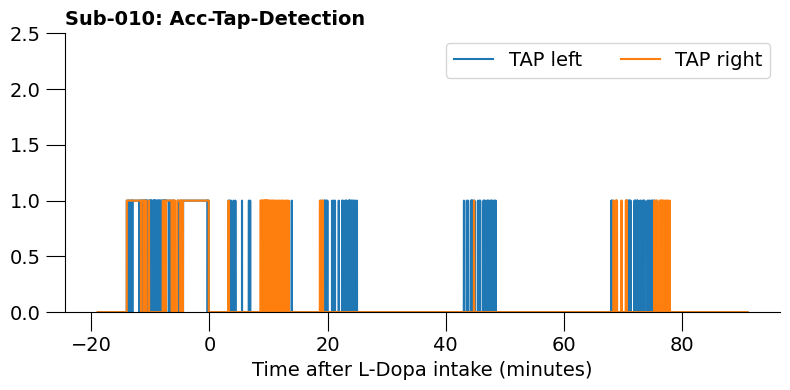

In [26]:
importlib.reload(prepTapPSD)
importlib.reload(movePSD)

INT_ACT_PLOT = False

# NOTE: (108?) CORRECT minute 15 to 20 is FREE instead of TAP
sub='010'
data_version='v4.0'


# loop over all subjects
# for sub in SUBS:

    # skip defined patients
    # if sub not in ['110',]: continue
# if sub not in new_subs: continue

# plot and save
# movePSD.plot_overview_tap_detection(acc, SAVE_FIG=True,)

# interactive plot

if INT_ACT_PLOT: %matplotlib qt
else: %matplotlib inline

plot_tap_interactive(sub=sub)


custom tap finding: 010, left


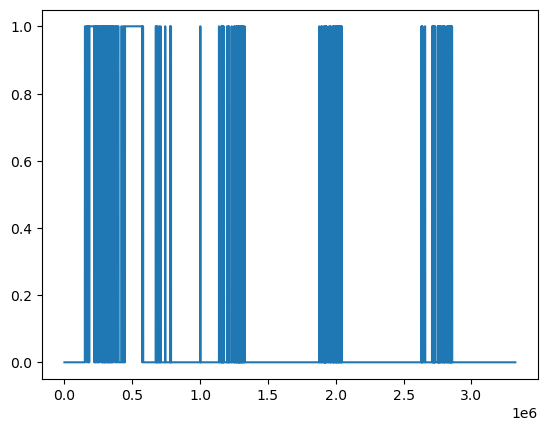

In [21]:
tap_i, tap_t, tap_bool = prepTapPSD.custom_tap_finding(
    acc, acc_side='left', move_type='tap',
)
plt.plot(tap_bool)

custom tap finding: 010, right


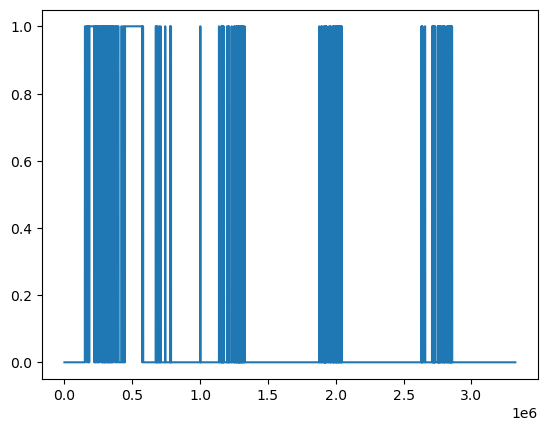

In [22]:
tap_i, tap_t, tap_bool = prepTapPSD.custom_tap_finding(
    acc, acc_side='right', move_type='tap',
)
plt.plot(tap_bool)

In [15]:
acc.colnames

['dopa_time',
 'ACC_L_X',
 'ACC_L_Y',
 'ACC_L_Z',
 'ANALOG',
 'task',
 'left_tap',
 'right_tap',
 'left_move',
 'right_move',
 'no_move']

In [17]:

fig, ax = plt.subplots(1,1, figsize=(32, 12))




# for i in [1,2,3]:
#         ax.plot(acc.data[:, 0] / 60,
#                 acc.data[:, i],
#                 label=acc.colnames[i])

svm = np.sqrt(acc.data[:, 1].astype(np.float64)**2 +
              acc.data[:, 2].astype(np.float64)**2 +
              acc.data[:, 3].astype(np.float64)**2)
ax.plot(acc.data[:, 0] / 60, svm, lw=3, alpha=.3,
         label='svm')

ax2 = ax.twinx()
ax2.plot(acc.data[:, 0] / 60, tap_bool)
# ax2.plot(acc.data[:, 0] / 60, acc.data[:, 5])

# x_peaks, props = signal.find_peaks(svm, height=.25e-6, distance=3*acc.fs)

# ax.scatter(acc.data[:, 0][x_peaks] / 60,
#            len(x_peaks) * [.25e-6],
#            s=50, color='purple', alpha=.5,)

# peak_indices = []
# margin = int(acc.fs/4)
# for i in x_peaks:
#     i_start, i_end = False, False
#     temp_i = i
#     # find start: first value below THR before peak
#     while not i_start:
#         temp_i -= 1
#         if all(svm[temp_i-margin:temp_i] < .5e-7): i_start = temp_i
#     # find end: first value below THR after peak
#     temp_i = i
#     while not i_end:
#         temp_i += 1
#         if all(svm[temp_i:temp_i+margin] < .5e-7): i_end = temp_i
#     # add values to peak_list
#     peak_indices.append([i, i_start, i_end])

# peak_indices = np.array(peak_indices)
# tap_bool = np.zeros_like(svm)
# for i1, i2 in zip(np.unique(peak_indices[:, 1]),
#                   np.unique(peak_indices[:, 2])):
#     tap_bool[i1:i2] = 1

# ax.scatter(acc.data[:, 0][peak_indices[:, 1]] / 60,
#            len(x_peaks) * [.5e-8],
#            s=50, color='orange', alpha=.5,)
# ax.scatter(acc.data[:, 0][peak_indices[:, 2]] / 60,
#            len(x_peaks) * [.5e-8],
#            s=50, color='green', alpha=.5,)



# ax.fill_between(x=acc.data[:, 0] / 60,
#                 y1=-5e-7, y2=5e-7, color='gray', alpha=.3,
#                 where=svm>2e-8, label='tap new')


# ax2 = ax.twinx()
# ax2.plot(acc.data[:, 0] / 60,
#          acc.data[:, 5],
#          label=acc.colnames[5])
# ax.legend()

### 1b. Load SSD data

In [ ]:
import lfpecog_features.get_ssd_data as ssd
import lfpecog_analysis.get_SSD_timefreqs as ssd_TimeFreq

In [ ]:
# get windowed bands of different dtypes per sub
# importlib.reload(ssd)

sub = '016'

# # call from feats_extract_multivar.py
# ssd_017 = ssd.get_subject_SSDs(
#     sub=sub,
#     incl_stn=True,
#     incl_ecog=True,
#     ft_setting_fname='ftExtr_spectral_v4.json',)

# call from feats_extract_multivar.py
ssd_sub = ssd.get_subject_SSDs(
    sub=sub,
    incl_stn=True,
    incl_ecog=False,
    ft_setting_fname='ftExtr_spectral_v4.json',)

### 2. Explore ACC-activity analysis

In [ ]:
sub = '017'

acc = {}

sub_data_path = os.path.join(main_data_path,
                                 f'sub-{sub}')
# fname = (f'{sub}_mergedData_{data_version}'
#             f'_acc_{side}.P')

# load Acc-detected movement labels
for side in ['left', 'right']:
    fname = (f'{sub}_mergedData_{data_version}'
                f'_acc_{side}.P')
    acc[side] = load_class_pickle(os.path.join(sub_data_path, fname))
    # fname = (f'{sub}_mergedData_{data_version}'
    #             f'_acc_right.P')
    # acc_r = load_class_pickle(os.path.join(sub_data_path, fname))

### 3. Explore Movement vs PSD analysis

In [ ]:
importlib.reload(prepTapPSD)

for sub in SUBS:
    # TODO:  '010'
    # if sub in ['016', '101',]: #continue
    if sub in new_subs:

        print(f'start sub-{sub}')
        # try:
        prepTapPSD.create_sub_movement_psds(
            sub=sub, states_to_save=['tap', 'rest_no_move', 'free_move', 'free_no_move'])
        # except:
        #     print(f'sub {sub} failed and skipped')
        #     continue

In [ ]:
def unpack_list_of_lists(lists_to_unpack):

    new_list = [i for j in lists_to_unpack for i in j]

    return new_list

In [ ]:
colors = list(plotHelp.get_colors().values())

In [ ]:
importlib.reload(movePSD)

# psd_rest, psd_tap, tap_f = movePSD.load_movement_psds()
state_psds, tap_f = movePSD.load_movement_psds()


In [ ]:
state_psds.keys()

In [ ]:
importlib.reload(tapPSD)


tapPSD.plotPSD_rest_vs_tap(PSDs=state_psds,
                           freqs=tap_f,
                           data_version=data_version,
                           n_subs_incl=17,
                           fig_name='STN_PSDs_Tap_vs_Rest_vs_Free'
                        )

#### 1b) Import processed dataclass per subject, optionally merge ACC-data into EPHYS-df

In [ ]:
# # Import subjectData Classes with alligned preprocessed Data
# importlib.reload(read_data)
# importlib.reload(add_moveStates)
# importlib.reload(findTap)

# incl_accStates = True

# subData = {}

# for sub in ['012', '014']:

#     print(f'start {sub}')
#     # if sub == '008': continue

#     subData[sub] = read_data.subjectData(
#         sub=sub,
#         data_version='v2.3',
#         project_path=projectpath,
#     )

#     if incl_accStates:
        
#         accStates = run_tap_detect.runTapDetection(subData[sub])

#         for group in subData[sub].dtypes:

#             if 'lfp' or 'ecog' in group:

#                 print(f'adding acc-states for {sub}: {group}')
#                 newdf = add_moveStates.add_detected_acc_states(
#                     df=getattr(subData[sub], group).data,
#                     detectedMoves=accStates,
#                 )
#                 getattr(subData[sub], group).data = newdf

### 2) Develop and Visualise Movement State Detection


#### Run single Acc-State Detections


In [ ]:
importlib.reload(run_tap_detect)
importlib.reload(movePrep)
importlib.reload(findTap)

taplists = {}
for sub in ['012',  '014']:  # '008', '013',
    print(sub)
    taplists[sub] = run_tap_detect.runTapDetection(subData[sub])

#### Visualise Performance of Tap/Move-detection

In [ ]:

fonts=20

for sub in list(subData.keys()):

    for x0, x1 in zip(
        # [9, 42],
        # [10, 43]
        [5, 37,],
        [15, 42]
    ):

        fig, axes = plt.subplots(2, 1, figsize=(16, 8))

        for s, side in enumerate(['left', 'right']):

            acc_df = getattr(subData[sub], f'acc_{side}').data  # per side
            fs = getattr(subData[sub], f'acc_{side}').fs

            ax = movePrep.find_main_axis(
                acc_df.iloc[:, 1:4].values
            )
            svm = movePrep.signalvectormagn(
                acc_df.iloc[:, 1:4].values
            )

            axes[s].plot(
                acc_df['dopa_time'] / 60,
                acc_df.iloc[:, ax + 1],
                alpha=.4, label='uni-axis'
            )
            axes[s].plot(
                acc_df['dopa_time'] / 60,
                movePrep.signalvectormagn(
                    acc_df.iloc[:, 1:4].values
                ), alpha=.4, label='svm', c='r', ls='dotted',
            )

            axes[s].scatter(
                np.array([l[0] for l in taplists2[sub][f'{side}_tap_t']]) / 60,
                [.65e-6] * len(taplists2[sub][f'{side}_tap_t']),
                s=50, color='g', label='tap-start',
            )
            axes[s].scatter(
                np.array([l[-1] for l in taplists2[sub][f'{side}_tap_t']]) / 60,
                [.6e-6] * len(taplists2[sub][f'{side}_tap_t']),
                s=50, color='r', label='tap-end'
            )
            axes[s].scatter(
                np.array([m[0] for m in taplists2[sub][f'{side}_move_t']]) / 60,
                [.55e-6] * len(taplists2[sub][f'{side}_move_t']),
                s=50, color='orange', label='move-start'
            )
            axes[s].scatter(
                np.array([m[1] for m in taplists2[sub][f'{side}_move_t']]) / 60,
                [.5e-6] * len(taplists2[sub][f'{side}_move_t']),
                s=50, color='purple', label='move-end'
            )

            axes[s].set_xlim(x0, x1)
            axes[s].set_ylim(-1e-6, 1e-6)
            axes[s].set_ylabel(
                f'Acceleration\n{side.upper()}'
                    '\n(g, m/s/s)',
                size=fonts
            )
            axes[s].tick_params(labelsize=fonts - 4)

        axes[s].set_xlabel('Time (minutes to L-Dopa intake)', size=fonts)


        plt.suptitle(
            f'Subject {sub} -  bilateral '
            'Movement detection',
            x=.1, y=.96, ha='left',
            size=fonts+4
        )
        # remove duplicate legend labels
        handles, labels = plotHelp.remove_duplicate_legend(
            plt.gca().get_legend_handles_labels()
        )

        fig.legend(
            handles, labels,
            frameon=False, fontsize=fonts - 4, ncol=3,
            loc='center left', bbox_to_anchor = [.55, .95])
        
        plt.tight_layout()

        # plt.savefig(os.path.join(
        #     fig_dir, 'tapping_detection',
        #     f'sub{sub}_moveDetect_newBorders_min{x0}_{x1}'
        # ), dpi=150, facecolor='w',)

        plt.close()

### VIsualisation Features

#### Manual Video-Movement Annotation

In [ ]:
# annotate observed taps in video, integers are seconds
# from video start
# CAVE: orignal Video-starttime is hour in front
# values here are corrected one hour backwards (12->11)
# Still the video-time seems to be +/- 3 minutes behind
# the acc-neurophys-time
taptimes_video = {
    'SelfpacedHandTapL_StimOffDopa15': {
        'left': [
            1154, 1160, 1164, 1169, 1174, 1180, 1185,
            1191, 1195, 1201, 1207, 1226, 1238, 1243,
            1248, 1253
        ],
        'right':[
            1260, 1264, 1270, 1275, 1281, 1290, 1298,
            1303, 1308, 1313, 1320, 1324, 1332, 1339,
            1345
        ],
        'starttime': '2021-11-15 11:29' 
        # original 11:26 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa35': {
        'left': [
            878, 883, 888, 893, 898, 903, 908, 915,
            919, 926, 933, 946, 951, 957, 963, 970,
            976, 984
        ],
        'right':[
            1000, 1006, 1011, 1017, 1024, 1028, 1035,
            1041, 1054, 1060, 1081, 1089, 1097, 1103,
            1108
        ],
        'starttime': '2021-11-15 11:51:01'
        # original 11:48 but corrected for mismatching times
    },
    'SelfpacedHandTapL_StimOffDopa60': {
        'left': [
            641, 647, 652, 657, 662, 666, 671, 676,
            682, 686, 692, 697, 703, 708, 713, 719,
        ],
        'right':[
            726, 730, 734, 740, 746, 751, 756, 761,
            768, 773, 779, 784, 792, 797, 801
        ],
        'starttime': '2021-11-15 12:22:59'  # video S1290007
        # original 12:20 but corrected for mismatching times
    }
}
# add timedelta in seconds to start-time of video
# CAVE videostarttime is on MINUTE-RESOLUTION
# thus will be SECONDS OF FROM ACC-TIMESTAMP
for run in taptimes_video:
    starttime = pd.Timestamp(taptimes_video[run]['starttime'])
    for side in ['left', 'right']:
        taptimes_video[run][f'{side}_stamps'] = []
        for sec in taptimes_video[run][side]:
            delta = pd.Timedelta(sec, 'sec')
            taptimes_video[run][f'{side}_stamps'].append(
                starttime + delta)

# Save annotation dict
# deriv_dir = os.path.join(
#     projectpath, 'data', 'analysis_derivatives', 'sub-008', 'taps'
# )
# dict_name = f'008_video_ann_tapruns'
# np.save(os.path.join(deriv_dir, dict_name),
#         taptimes_video)

# # Load annotation dict
# video_taps = np.load(os.path.join(deriv_dir, f'{dict_name}.npy'),
#                      allow_pickle=True).item()


In [ ]:
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
testannot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()
# testannot


#### Automated Acc-based Tap detection incl. plotting

In [ ]:
run = 'SelfpacedHandTapL_StimOffDopa35'
sides = ['left', 'right']
tap_fig_dir = os.path.join(projectpath, 'figures/tapping_detection')

In [ ]:
importlib.reload(tap_run)

restTest, tapTest, _ = tap_run.runTapDetection(
    task='paused', fs=SUB08.runs[run].acc_right_Fs,
    leftxyz=[accleft[run][0, :], accleft[run][1, :],
    accleft[run][2, :]], rightxyz=[accright[run][0, :],
    accright[run][1, :], accright[run][2, :]],
)

In [ ]:
### Main function to perform TapDetection functions
    ## make new main-function

importlib.reload(Tap2)

# accright, accleft = {}, {}
# restDict, tapDict, moveDict = {}, {}, {}

for run in SUB08.runs_incl[1:]:
    print(f'Start RUN: {run}')
    fs=SUB08.runs[run].acc_right_Fs
    accright[run] = SUB08.runs[run].acc_right_arr[1:, :]
    accleft[run] = SUB08.runs[run].acc_left_arr[1:, :]

    restDict[run], tapDict[run], moveDict[run] = runTapDetection(
        task='paused', fs=SUB08.runs[run].acc_right_Fs,
        leftxyz=[accleft[run][0, :], accleft[run][1, :],
        accleft[run][2, :]], rightxyz=[accright[run][0, :],
        accright[run][1, :], accright[run][2, :]],
    )


In [ ]:
### (function to be) get runstartTimes (include in RUN CLASS (real and dopa times))
deriv_dir = os.path.join(projectpath, 'data/analysis_derivatives')
runTimes = pd.read_excel(
    os.path.join(deriv_dir, f'sub-{sub}', f'sub{sub}_runsInfo.xlsx'))

runStartTimes = {}
for run in SUB08.runs_incl:
    for row in np.arange(runTimes.shape[0]):
        if run[-6:] in runTimes.iloc[row]['filename']:
            t = runTimes.iloc[row]['acq_time']
            runStartTimes[run] = pd.Timestamp(t)

In [ ]:
### Import and process video-annotated tap-times ###

## (function to be) Convert video-annotated tap-stamps
## into seconds after tmsi-recording

# import annotated taptimes (function to be?)
sub = '008'
annot_dir = os.path.join(projectpath, f'data/analysis_derivatives/sub-{sub}/taps')
tapAnnot = np.load(os.path.join(annot_dir, f'{sub}_video_ann_tapruns.npy'),
    allow_pickle=True).item()

ann_times = {}
tapsAnnot_in_runSecs = {}

for run in tapDict.keys():
    if 'Tap' not in run: continue

    # real-time timestamps of video-annotated taps
    dt_string = '%Y-%m-%d %H:%M:%S'
    t0 = tapAnnot[run]['starttime']
    try:
        t0 = dt.datetime.strptime(t0, dt_string)
    except ValueError:
        t0 = dt.datetime.strptime(t0, '%Y-%m-%d %H:%M')

    ann_times[run] = {}
    tapsAnnot_in_runSecs[run] = {}

    for side in sides:
        ann_times[run][side] = [t0 + dt.timedelta(
            seconds=t) for t in tapAnnot[run][side]]
    # minus video start-time -> time after video-start
        tapsAnnot_in_runSecs[run][side] = [
            (t - runStartTimes[run]).total_seconds(
            ) for t in ann_times[run][side]
        ]


In [ ]:
### TO DO:
# - WHY IS check_Polarity turning the signal falsely?
# - Why is tapdetection from TapDopa15 Right empty? 
    # plot incl peaks and thresholds etc

# - include plotting of OTHER MVOEMENTS
# - split py function for tapping in several py docs!!

In [ ]:
### Create plotting functions for tapping

from matplotlib.gridspec import GridSpec

run = list(tapsAnnot_in_runSecs.keys())[2]

print(f'Plot Figure for run {run}')
# specify x-coordinates of zoomed-in subplots
ax1_x1, ax1_x2 = 72, 80
ax2_x1, ax2_x2 = 150, 160
plot_fname=f'TapDetect_08_{run}'
if ax1_x1: plot_fname += f'_zooms_{ax1_x1}_{ax2_x1}'
plot_fdir=tap_fig_dir

plot_params = {
        'left': {
            'color': 'b',
            'alpha': .6
        },
        'right': {
            'color': 'g',
            'alpha': .6
        },
        'rest': {
            'color': 'orange',
            'alpha': .3
        },
        'left_up': {
            'color': 'dodgerblue',
            'alpha': .5
        },
        'left_down': {
            'color': 'cyan',
            'alpha': .5
        },
        'left_other': {
            'facecolor': 'white',
            'edgecolor': 'dodgerblue',
            'alpha': .8,
            'hatch': '//'
        },
        'right_up': {
            'color': 'forestgreen',
            'alpha': .5
        },
        'right_down': {
            'color': 'lime',
            'alpha': .5
        },
        'right_other': {
            'facecolor': 'white',
            'edgecolor': 'forestgreen',
            'alpha': .8,
            'hatch': '//'
        }
    }

fig = plt.figure(constrained_layout=True, figsize=(16, 12))
gs = GridSpec(3, 9, figure=fig)

ax0 = fig.add_subplot(gs[:2, :])
ax1 = fig.add_subplot(gs[2, :4])
ax2 = fig.add_subplot(gs[2, 5:], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

for ax in [ax0, ax1, ax2]:
    # Plotting traces
    ax.plot(
        np.arange(0, accleft[run][1, :].shape[0]) / fs,
        accleft[run][1, :], **plot_params['left'],
        label='Left ACC-trace',
    )
    ax.plot(
        np.arange(0, accright[run][1, :].shape[0]) / fs,
        accright[run][1, :], **plot_params['right'],
        label='Right ACC-trace',
    )
    # Plot bilateral Rest-epochs
    for d in restDict[run]:
        ax.fill_betweenx(label='Bilat. Rest detected',
            y=[-1e-6, 1e-6], x1=restDict[run][d][0],
            x2=restDict[run][d][1],
            **plot_params['rest'],)

    # Plot Tap and other-movem. epochs
    for side in ['left', 'right']:
        ## plot Taps
        for t, tList in enumerate(tapDict[run][side]):
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[0], x2=tList[2],
                label=f'{side} Up detected',
                **plot_params[f'{side}_up'],
            )
            # ax.scatter(tList[1], )  # plot fastest point
            ax.fill_betweenx(
                y=[-3e-6, 3e-6],
                x1=tList[3], x2=tList[4],
                label=f'{side} Down detected',
                **plot_params[f'{side}_down'],
            )
        
        ## Plot Other Movement's
        for t, tList in enumerate(moveDict[run][side]):
            ax.fill_betweenx(
                y=[-1e-6, 1e-6],
                x1=tList[0], x2=tList[1],
                label=f'{side} Other Mov. detected',
                **plot_params[f'{side}_other'],
            )
        
        ## Plot Accuracy circles based on video-annotations
        vid_circle_pos = tapsAnnot_in_runSecs[run][side]
        acc_circle_pos = [t[0] for t in tapDict[run][side]]
        ax0.scatter(
            vid_circle_pos, [3.5e-6] * len(vid_circle_pos),
            s=150, edgecolor='k', facecolor='w', lw=2,
            label='Video-annotated Tap', **plot_params['left'],
        )
        ax0.scatter(
            acc_circle_pos, [3.5e-6] * len(acc_circle_pos),
            s=120, color=plot_params[side]['color'], alpha=.3,
            label=f'Acc-classified Tap {side}'
        )
        tapAcc_handles, tapAcc_labels = ax0.get_legend_handles_labels()
        tapAcc_handles = tapAcc_handles[-3:]
        tapAcc_labels = tapAcc_labels[-3:]
        ax0.legend(tapAcc_handles, tapAcc_labels,
            fontsize=16, ncol=3, frameon=False,
            loc='upper center', bbox_to_anchor=(.5, .99))

        # plot findpeak dots to optimize algorithm
        # posPeaks = signal.find_peaks(
        #     accleft[run][1, :],
        #     height=np.max(accleft[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='k')
        # posPeaks = signal.find_peaks(
        #     accright[run][1, :],
        #     height=np.max(accright[1, :]) * .5,
        #     distance=fs,  # 1 s
        # )
        # ax.scatter(posPeaks[0] / fs, posPeaks[1]['peak_heights'], c='gray')
        
        
    # make plots pretty
    ax.set_xlabel('Time (sec)', size=20)
    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # helping lines for alforithm finetuning
    # ax.axhline(np.median(spos), label='median')
    # ax.axhline(np.percentile(spos, 75), label='75-%', ls='dotted')
    # ax.axhline(-np.percentile(spos, 75), label='-75-%', color='red', ls='dotted')

# make plot pretty
for ax in [ax0, ax1]: ax.set_ylabel('Acceleration (m/s/s)', size=20)
ax2.spines['left'].set_visible(False)

# define zoomed subplots
ax1.set_xlim(ax1_x1, ax1_x2)
ax2.set_xlim(ax2_x1, ax2_x2)

# get rid off duplicate legend labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(),
    fontsize=20, frameon=False, ncol=3,
    loc='upper left', bbox_to_anchor=(.03, -.01)
)
plt.suptitle(f'sub008: {run}', x=.8, y=.99,
    color='gray', alpha=.8, fontsize=16,)
# plt.tight_layout(pad=.1)

plt.savefig(os.path.join(plot_fdir, plot_fname),
    dpi=150, facecolor='white', bbox_inches='tight')

plt.show()

In [ ]:
### PLOTTING ###
## using xyz input and output-indices of pausedTap function
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(xEpoch, label='x', alpha=.5, c='blue')
ax.plot(yEpoch, label='y', alpha=.8, c='green')
ax.plot(zEpoch, label='z', alpha=.5, c='orange')
# plot vertical lines at tap-moments
for t, tap in enumerate(tapi):
    if t == 0:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5, label='start UP')
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5, label='end UP')
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5, label='start DOWN')
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5, label='end DOWN')
    else:
        ax.axvline(tap[0], c='green', ls='dotted', alpha=.5,)
        ax.axvline(tap[1], c='green', ls='solid', alpha=.5,)
        ax.axvline(tap[2], c='purple', ls='dotted', alpha=.5,)
        ax.axvline(tap[3], c='purple', ls='solid', alpha=.5,)

peaklabel = ['lowPos', 'highPos', 'lowNeg', 'highNeg']
peakcol = ['lightgreen', 'green', 'orange', 'r']
for p, peaks in enumerate([smallPos, largePos, smallNeg, largeNeg]):
    ax.scatter(
        peaks[0],
        yEpoch[peaks[0]],
        label=peaklabel[p],
        color=peakcol[p],
        s=50,
    )

for mov in movei:  # check saved otherMovements
    ax.axvline(mov[0], color='gray', lw=1, ls='dotted')
    ax.axvline(mov[-1], color='gray', lw=1)

# ax.axhline(-.5e-7)
ax.axhline(posThr)
ax.axhline(0, c='gray', lw=.5,)
# determine what to show
ax.set_ylim(-2.5e-6, 2.5e-6)
# ax.set_xlim(istart, istop)
ax.set_xlim(0, 30000)
# ax.set_xticks(np.arange(18600, 20001, 200))
# ax.set_xticklabels(np.arange(18600, 20001, 200) // 200)
xticks = np.arange(0, len(yEpoch), 6000)
xlabs = np.arange(0, len(yEpoch) / 12000, .5)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_ylabel('Raw Acceleration (m/s/s)', size=14)
ax.set_xlabel('Time (minutes)', size=14)

ax.set_title(run)

# ax.legend(frameon=False, fontsize=14, loc='upper right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot Rest-moments
for idx in resti:
    ax.fill_betweenx(
        y=np.linspace(-3e-6, 3e-6, 5), x1=idx[0], x2=idx[1],
        color='blue', alpha=.1,)

if to_save:
    plt.savefig(
        os.path.join(temp_save, 'ACC', f'mountFingerTap_sub08_{run[-6:]}_2'),
        dpi=300, facecolor='w',
    )
plt.show()

print(f'{run} finisihed')